In [109]:
GC.gc() # Clear up the memory when doing a "run all" in the notebook

using Plots
gr()

include("src/load_profiles.jl")
include("src/solverFixedProdStorage.jl")
include("src/solverFixedProd.jl");

In [110]:
filename = "profiles.csv"
time_profiles, wind_profiles, solar_profiles = Dict(), Dict(), Dict()
time_profiles, wind_profiles, solar_profiles = load_profiles(filename);

### We first define the global parameters of the problem, to have consistent results across solving methods

In [111]:
# Default values
DEMAND = 1000. # Kg of H2
# Battery parameters
EBAT = 0.9 # per month discharge
FBAT = 100. # MW
COST_BAT = 250000 * 0.0002 # € / MWh
CAPA_BAT_UPPER = 40000 # MWh, 40 GWh
# Electrolyzer parameters
EELEC = 0.050 # Mwh / Kg
COST_ELEC =  1200000 * 0.0004 # € / MW
CAPA_ELEC_UPPER = 1000 # MW
# Tank parameters
COST_TANK = 407. # € / Kg
# Grid parameters
PRICE_GRID = 1000. # € / MWh
PRICE_CURTAILING = 1000. # € / MWh;
PRICE_PENALITY = 10. # € / times changed
#Year for the computes
YEAR = 2017;

# First Step :
## Solve the problem given the production and storage capacities

In [112]:
# We use the default values for now
BAT_SIZE = 400. # MWh
TANK_SIZE = 500. # Kg
ELEC_CAPA = 1000. # MW
time_index = wind_profiles[YEAR]
wind_profile = wind_profiles[YEAR]
solar_profile = solar_profiles[YEAR]
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = D * length(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile);

In [113]:
output = solveFixedProdStorage(
    wind_capa,
    solar_capa,
    wind_profile,
    solar_profile,
    BAT_SIZE,
    TANK_SIZE,
    ELEC_CAPA,
    DEMAND,
    PRICE_GRID, # Grid electricity price
    PRICE_CURTAILING, # Curtailing price
    PRICE_PENALITY, # Production change penality
    EBAT,
    FBAT,
    EELEC,
    COST_ELEC,
    COST_BAT,
    COST_TANK,
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96363 rows, 87602 columns and 245278 nonzeros
Model fingerprint: 0xcf3d6441
Variable types: 78843 continuous, 8759 integer (8759 binary)
Coefficient statistics:
  Matrix range     [5e-02, 4e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e+00, 1e+03]
Presolve removed 52568 rows and 35046 columns
Presolve time: 0.17s
Presolved: 43795 rows, 52556 columns, 131388 nonzeros
Variable types: 43797 continuous, 8759 integer (8759 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 3.51s

Solved with primal simplex

Root relaxation: objective 1.564793e+08

In [114]:
storage_cost = output["storage_cost"]
operating_cost = output["operating_cost"]
electrolyser_cost = output["electrolyser_cost"]
println("Storage cost: $storage_cost, operating cost: $operating_cost, electrolyser cost : $electrolyser_cost")
println("Total cost: $(storage_cost + operating_cost + electrolyser_cost)")
println("Battery capacity: $BAT_SIZE, Tank capacity: $TANK_SIZE kg, Electrolyser capacity: $(ELEC_CAPA / EELEC) kg/h")

Storage cost: 223500.0, operating cost: 1.5648695146154734e8, electrolyser cost : 480000.0
Total cost: 1.5719045146154734e8
Battery capacity: 400.0, Tank capacity: 500.0 kg, Electrolyser capacity: 20000.0 kg/h


In [115]:
prod_out = output["prod"]
charge_out = output["charge"]
stock_out = output["stock"]
elec_out = output["elecGrid"]
curtailment_out = output["curtail"]
consPPA_out = output["elecPPA"];

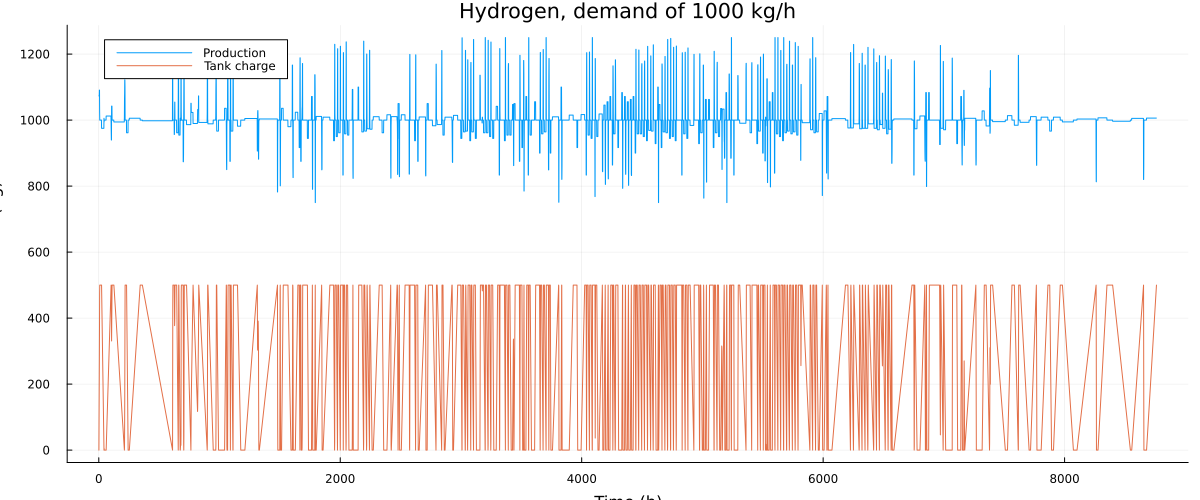

In [116]:
# Plot the production & tank charge over time
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Production (Kg)", title="Hydrogen, demand of $D kg/h")
plot!(prod_out, label="Production")
plot!(stock_out, label="Tank charge")

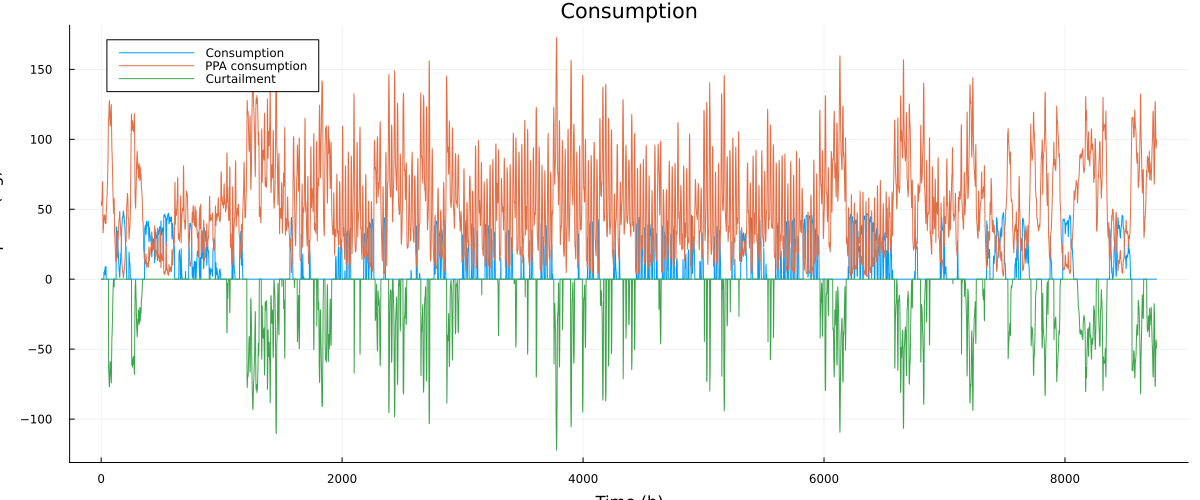

In [117]:
# Plot the consumptions, curtailment and battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Consumption (Kg)", title="Consumption")
plot!(elec_out, label="Consumption")
plot!(consPPA_out, label="PPA consumption")
plot!(-curtailment_out, label="Curtailment")

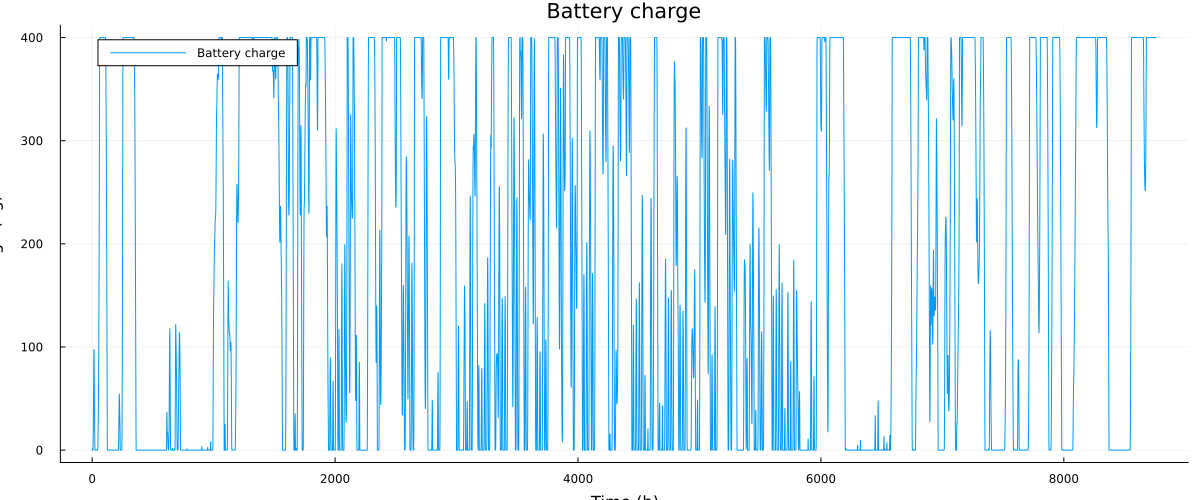

In [118]:
# Plot the battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Charge (Kg)", title="Battery charge")
plot!(charge_out, label="Battery charge")

# Second Step :
## Solve the problem given the production capacities only

In [119]:
# We use the default values for now
D = 1000.
time_index = wind_profiles[YEAR]
wind_profile = wind_profiles[YEAR]
solar_profile = solar_profiles[YEAR]
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = D * length(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile);

In [120]:
output = solveFixedProd(
    wind_capa,
    solar_capa,
    wind_profile,
    solar_profile,
    DEMAND,
    PRICE_GRID, # Grid electricity price
    PRICE_CURTAILING, # Curtailing price
    PRICE_PENALITY, # Production change penality
    CAPA_ELEC_UPPER,
    CAPA_BAT_UPPER,
    EBAT,
    FBAT,
    EELEC,
    COST_ELEC,
    COST_BAT,
    COST_TANK
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96365 rows, 87607 columns and 271565 nonzeros
Model fingerprint: 0xf814da34
Variable types: 78848 continuous, 8759 integer (8759 binary)
Coefficient statistics:
  Matrix range     [5e-02, 4e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 4e+04]
  RHS range        [1e+00, 1e+03]
Presolve removed 26289 rows and 35047 columns
Presolve time: 0.19s
Presolved: 70076 rows, 52560 columns, 183948 nonzeros
Variable types: 43801 continuous, 8759 integer (8759 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   40975  

In [121]:
battery_capa = trunc(Int64, output["battery_capa"])
tank_capa = trunc(Int64, output["tank_capa"])
electro_capa = trunc(Int64, output["electro_capa"])
println("Battery capacity: $battery_capa, Tank capacity: $tank_capa kg, Electrolyser capacity: $(electro_capa / EELEC) kg/h")

storage_cost = output["storage_cost"]
operating_cost = output["operating_cost"]
electrolyser_cost = output["electrolyser_cost"]
println("Storage cost: $storage_cost, operating cost: $operating_cost, electrolyser cost : $electrolyser_cost")
println("Total cost: $(storage_cost + operating_cost + electrolyser_cost)")

Battery capacity: 19162, Tank capacity: 0 kg, Electrolyser capacity: 1000.0 kg/h
Storage cost: 958121.7005875829, operating cost: 1.0916889986922815e7, electrolyser cost : 24000.0
Total cost: 1.18990116875104e7


In [122]:
prod_out = output["prod"]
charge_out = output["charge"]
stock_out = output["stock"]
elec_out = output["elecGrid"]
curtailment_out = output["curtail"]
consPPA_out = output["elecPPA"];

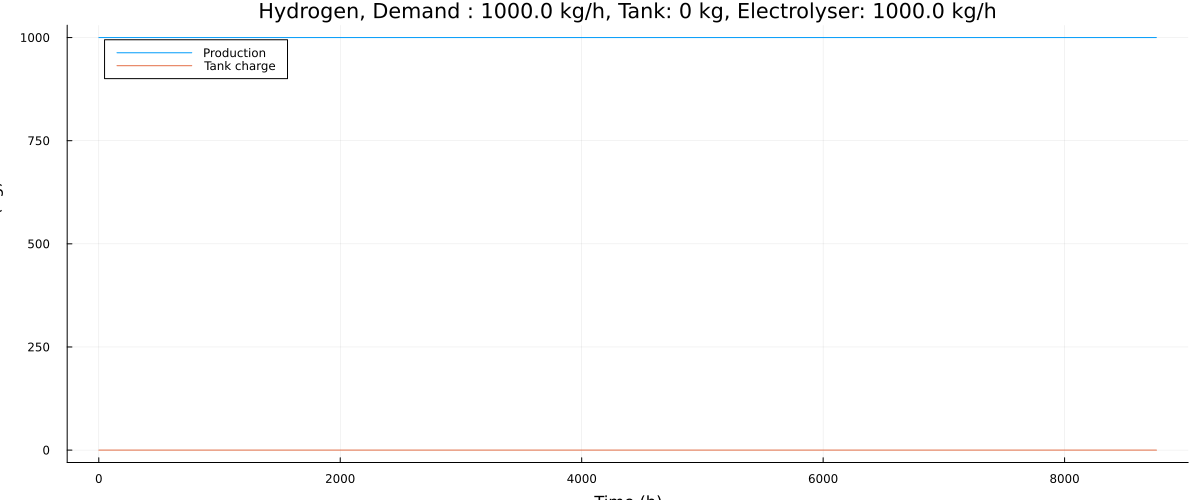

In [123]:
# Plot the production & tank charge over time
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Production (Kg)",
 title="Hydrogen, Demand : $D kg/h, Tank: $tank_capa kg, Electrolyser: $(electro_capa / EELEC) kg/h")
plot!(prod_out, label="Production")
plot!(stock_out, label="Tank charge")

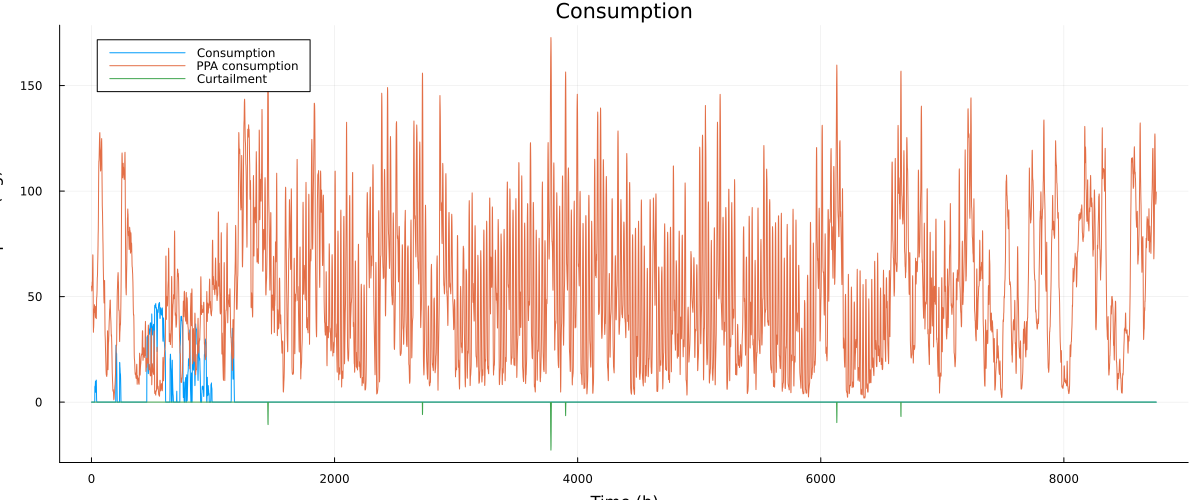

In [124]:
# Plot the consumptions, curtailment and battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Consumption (Kg)", title="Consumption")
plot!(elec_out, label="Consumption")
plot!(consPPA_out, label="PPA consumption")
plot!(-curtailment_out, label="Curtailment")

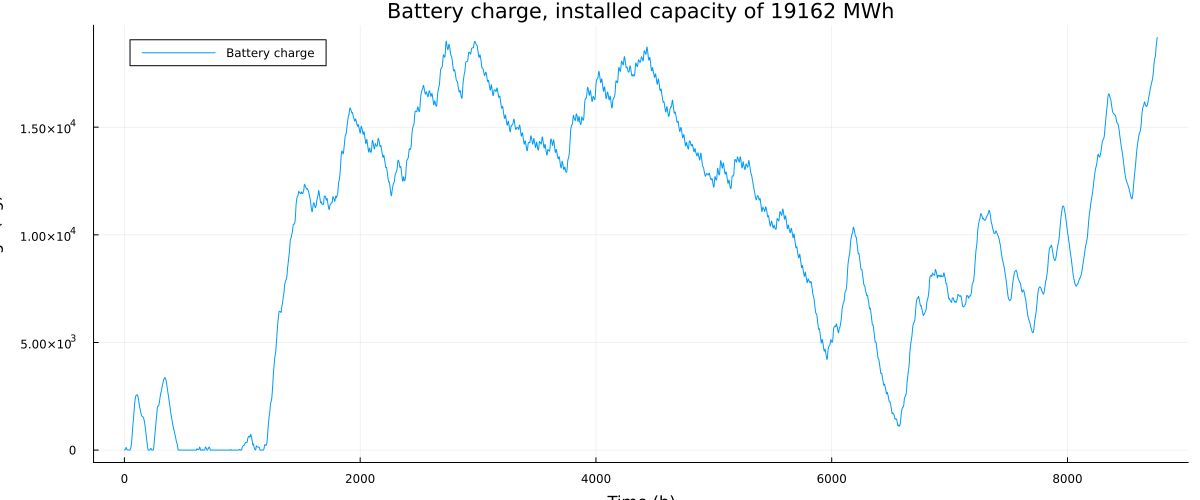

In [125]:
# Plot the battery charge
plot(size=(1200, 500), legend=:topleft, xlabel="Time (h)", ylabel="Charge (Kg)", title="Battery charge, installed capacity of $battery_capa MWh")
plot!(charge_out, label="Battery charge")